# Define similarity measures

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import jaccard_score as jaccard_similarity

def dot_similarity(vector1, vector2):
    return np.sum(np.multiply(np.array(vector1), np.array(vector2)))

def cosine_similarity(vector1, vector2):
    return dot_similarity(vector1, vector2) / np.sqrt(np.sum(vector1)**2 * np.sum(vector2)**2)

# Data tokenization

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
# ‘english’
def get_boolean_representation(corpus, stop_words_list='english'):
    vectorizer = CountVectorizer(binary=True, stop_words=stop_words_list)
    X = vectorizer.fit_transform(corpus)
    return X.toarray(), vectorizer.get_feature_names_out()

def get_tf_representation(corpus, stop_words_list='english'):
    vectorizer = CountVectorizer(binary=False, stop_words=stop_words_list)
    X = vectorizer.fit_transform(corpus)
    vectorizer.get_feature_names_out()
    return X.toarray()

def get_tf_idf_representation(corpus, stop_words_list='english'):
    vectorizer = TfidfVectorizer(stop_words=stop_words_list)
    X = vectorizer.fit_transform(corpus)
    vectorizer.get_feature_names_out()
    return X.toarray()

# Experiments for k-means

We realise two k-means (one for each labels) to try to group the sentences together, in order sentences that are related will be in the same cluster for example for label 0 : if some sentences are about fishing and others about architecture we want them to be separated to create more specific centroids.

In [9]:
import pandas as pd

df_train = pd.read_csv("../data/DataFrame_train_PREPROCESS.csv")
df_val = pd.read_csv("../data/DataFrame_val_PREPROCESS.csv")

index_train = df_train['index']
index_val = df_val['index']

df = pd.concat([df_train, df_val], ignore_index = True, sort = False)

representation_boolean, vocabulary = get_boolean_representation(df['text'].apply(lambda x : x.lower()))
representation_tf = get_tf_representation(df['text'].apply(lambda x : x.lower()))
representation_tf_idf = get_tf_idf_representation(df['text'].apply(lambda x : x.lower()))

del df

x_train_boolean = representation_boolean[:len(index_train)]
x_val_boolean = representation_boolean[len(index_train):]

x_train_tf = representation_tf[:len(index_train)]
x_val_tf = representation_tf[len(index_train):]

x_train_tf_idf = representation_tf_idf[:len(index_train)]
x_val_tf_idf = representation_tf_idf[len(index_train):]

y_train = df_train['label']
y_val = df_val['label']

del df_val
del df_train

In [10]:
from sklearn.cluster import KMeans

class k_means_centroids_model:
    centroids = None
    centroids_labels = None
    n_cluster_1=1
    n_cluster_0=1
    k_means_labels = None

    def get_k_means_labels(self):
        if self.k_means_labels is None:
            print('Error : class must be fitted before')
            exit(-1)
        else:
            return self.k_means_labels[0], self.k_means_labels[1]


    def get_centroids(self):
        if self.centroids is None:
            print('Error : class must be fitted before')
            exit(-1)
        else:
            return self.centroids[0], self.centroids[1]


    def get_centroids_labels(self):
        if self.centroids_labels is None:
            print('Error : class must be fitted before')
            exit(-1)
        else:
            return self.centroids_labels


    def fit(self, data, labels,  n_cluster_1=1, n_cluster_0=1):
        self.n_cluster_1 = n_cluster_1
        self.n_cluster_0 = n_cluster_0
        index_label_0 = np.argwhere(np.array(labels) == 0).reshape(-1)
        index_label_1 = np.argwhere(np.array(labels) == 1).reshape(-1)

        # k-means for label 1
        kmeans_1 = KMeans(n_clusters=n_cluster_1, random_state=0).fit(data[index_label_1])

        # k-means for label 0
        kmeans_0 = KMeans(n_clusters=n_cluster_0, random_state=0).fit(data[index_label_0])

        self.k_means_labels = kmeans_1.labels_, kmeans_0.labels_
        self.centroids = kmeans_1.cluster_centers_, kmeans_0.cluster_centers_
        self.centroids_labels = np.append((np.zeros(n_cluster_1)+1).astype(int), [(np.zeros(n_cluster_0)).astype(int)])


    def predict(self, data, similarity='cosine'):
        if self.centroids is None or self.centroids_labels is None :
            print('Error : class must be fitted before prediction')
            exit(-1)


        """cluster_label = [i if dot_similarity(entry, self.centroids[i]) > dot_similarity(entry, self.centroids[i+1]) else i+1 \
                         for i in range(len(self.centroids_labels) - 1) \
                         for entry in data
                         ]"""

        if similarity == 'dot':
            max_in_label_0 = [np.max([dot_similarity(entry, self.centroids[1][j]) for j in range(self.n_cluster_0)]) for entry in data]
            max_in_label_1 = [np.max([dot_similarity(entry, self.centroids[0][j]) for j in range(self.n_cluster_1)]) for entry in data]
            return [1 if max_in_label_1[i] > max_in_label_0[i] else 0 for i in range(len(max_in_label_1))]
        else:
            max_in_label_0 = [np.max([cosine_similarity(entry, self.centroids[1][j]) for j in range(self.n_cluster_0)]) for entry in data]
            max_in_label_1 = [np.max([cosine_similarity(entry, self.centroids[0][j]) for j in range(self.n_cluster_1)]) for entry in data]
            return [1 if max_in_label_1[i] > max_in_label_0[i] else 0 for i in range(len(max_in_label_1))]

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

results_boolean = pd.DataFrame(columns=['n_cluster_lab_1', 'n_cluster_lab_2', 'acc', 'aucroc'])
results_tf = pd.DataFrame(columns=['n_cluster_lab_1', 'n_cluster_lab_2', 'acc', 'aucroc'])
results_tf_idf = pd.DataFrame(columns=['n_cluster_lab_1', 'n_cluster_lab_2', 'acc', 'aucroc'])


for n_1 in range(1, 4):
    for n_2 in range(1, 8):

        print(n_1, n_2)

        model = k_means_centroids_model()
        model.fit(x_train_boolean, y_train, n_cluster_1=n_1, n_cluster_0=n_2)
        y_predict = model.predict(x_val_boolean, similarity='cosine_similarity')
        results_boolean = results_boolean.append(pd.DataFrame({'n_cluster_lab_1':[n_1],'n_cluster_lab_2':[n_2],'acc':[accuracy_score(y_val, y_predict)],'aucroc':[roc_auc_score(y_val, y_predict)]}))

        model = k_means_centroids_model()
        model.fit(x_train_tf_idf, y_train, n_cluster_1=n_1, n_cluster_0=n_2)
        y_predict = model.predict(x_val_tf_idf, similarity='cosine_similarity')
        results_tf = results_tf.append(pd.DataFrame({'n_cluster_lab_1':[n_1],'n_cluster_lab_2':[n_2],'acc':[accuracy_score(y_val, y_predict)],'aucroc':[roc_auc_score(y_val, y_predict)]}))

        model = k_means_centroids_model()
        model.fit(x_train_tf, y_train, n_cluster_1=n_1, n_cluster_0=n_2)
        y_predict = model.predict(x_val_tf, similarity='cosine_similarity')
        results_tf_idf = results_tf_idf.append(pd.DataFrame({'n_cluster_lab_1':[n_1],'n_cluster_lab_2':[n_2],'acc':[accuracy_score(y_val, y_predict)],'aucroc':[roc_auc_score(y_val, y_predict)]}))

        print(results_boolean)

results_boolean.to_csv('k_means_boolean_repr_cosine_1_7.csv')
results_tf.to_csv('k_means_tf_repr_cosine_1_7.csv')
results_tf_idf.to_csv('k_means_tf_idf_repr_cosine_1_7.csv')

1 1
  n_cluster_lab_1 n_cluster_lab_2     acc    aucroc
0               1               1  0.6475  0.771895
1 2
  n_cluster_lab_1 n_cluster_lab_2     acc    aucroc
0               1               1  0.6475  0.771895
0               1               2  0.8125  0.872362
1 3
  n_cluster_lab_1 n_cluster_lab_2     acc    aucroc
0               1               1  0.6475  0.771895
0               1               2  0.8125  0.872362
0               1               3  0.7925  0.859664
1 4
  n_cluster_lab_1 n_cluster_lab_2     acc    aucroc
0               1               1  0.6475  0.771895
0               1               2  0.8125  0.872362
0               1               3  0.7925  0.859664
0               1               4  0.9200  0.910551
1 5
  n_cluster_lab_1 n_cluster_lab_2     acc    aucroc
0               1               1  0.6475  0.771895
0               1               2  0.8125  0.872362
0               1               3  0.7925  0.859664
0               1               4  0.9200  0

In [12]:
print("Results for boolean representation")
print(results_boolean)
print('\n')
print("Results for tf representation")
print(results_tf)
print('\n')
print("Results for tf-idf representation")
print(results_tf_idf)
print('\n')

Results for boolean representation
  n_cluster_lab_1 n_cluster_lab_2     acc    aucroc
0               1               1  0.6475  0.771895
0               1               2  0.8125  0.872362
0               1               3  0.7925  0.859664
0               1               4  0.9200  0.910551
0               1               5  0.9150  0.920261
0               1               6  0.9225  0.920728
0               1               7  0.9225  0.916433
0               2               1  0.4750  0.666667
0               2               2  0.7125  0.817460
0               2               3  0.6750  0.793651
0               2               4  0.8925  0.901681
0               2               5  0.8725  0.901867
0               2               6  0.8900  0.908683
0               2               7  0.8975  0.909150
0               3               1  0.3900  0.612698
0               3               2  0.5625  0.722222
0               3               3  0.5525  0.715873
0               3            

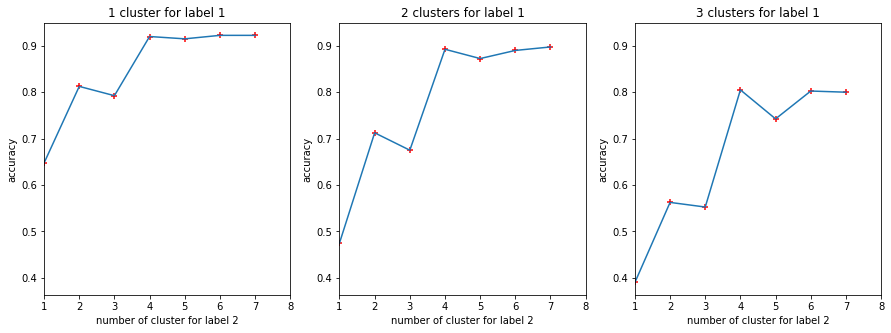

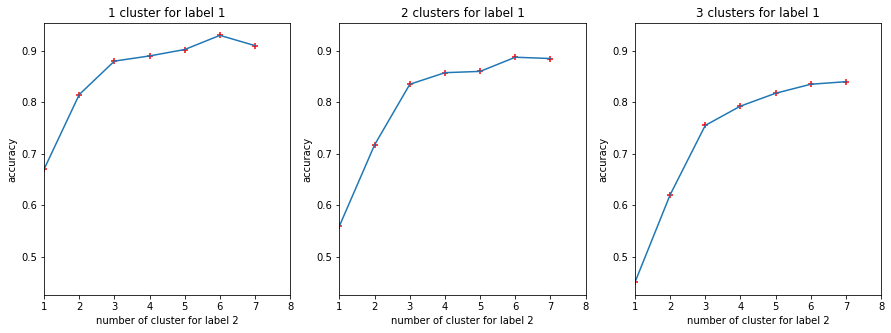

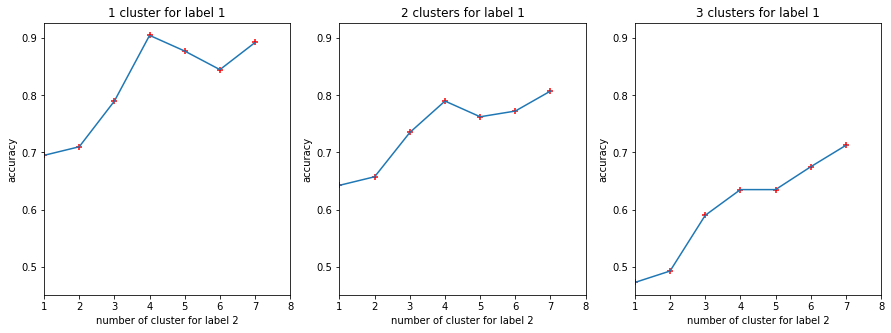

In [13]:
import matplotlib.pyplot as plt

z = 0
filename = ['accuracy_boolean_repr_1_7.png', 'accuracy_tf_repr_1_7.png', 'accuracy_tf_idf_repr_1_7.png']
for df in [results_boolean, results_tf, results_tf_idf]:
    fig = plt.figure(figsize=(15,5))
    fig.title =  'Accuracy depending on the number of clusters'

    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
    ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)

    x, y = np.array(df[df['n_cluster_lab_1'] == 1]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 1]['acc'].tolist())
    ax1.plot(x, y)
    ax1.scatter(x, y, c='red', marker='+')
    ax1.set_title("1 cluster for label 1")
    ax1.set_xlim([1,8])
    ax1.set_xlabel("number of cluster for label 2")
    ax1.set_ylabel("accuracy")

    x, y = np.array(df[df['n_cluster_lab_1'] == 2]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 2]['acc'].tolist())
    ax2.plot(x, y)
    ax2.scatter(x, y, c='red', marker='+')
    ax2.set_title("2 clusters for label 1")
    ax2.set_xlim([1,8])
    ax2.set_xlabel("number of cluster for label 2")
    ax2.set_ylabel("accuracy")

    x, y = np.array(df[df['n_cluster_lab_1'] == 3]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 3]['acc'].tolist())
    ax3.plot(x, y)
    ax3.scatter(x, y, c='red', marker='+')
    ax3.set_title("3 clusters for label 1")
    ax3.set_xlim([1,8])
    ax3.set_xlabel("number of cluster for label 2")
    ax3.set_ylabel("accuracy")

    plt.show()
    fig.savefig(fname=filename[z])
    z += 1

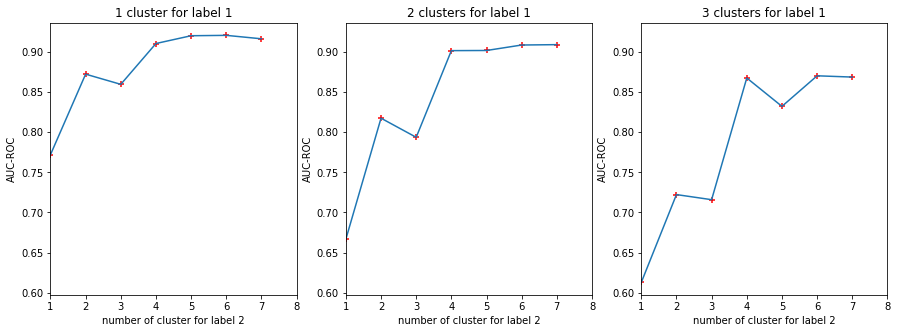

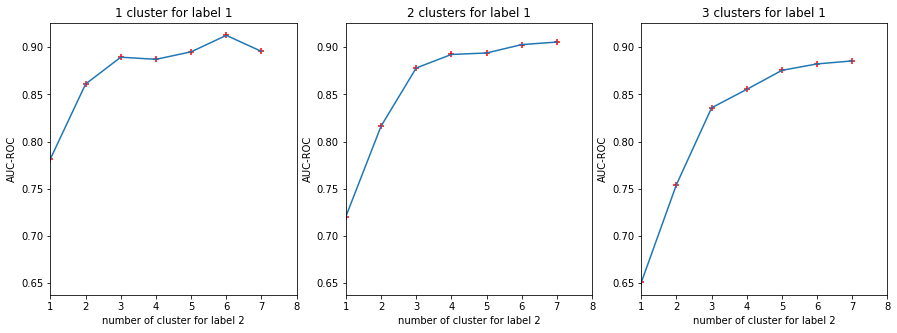

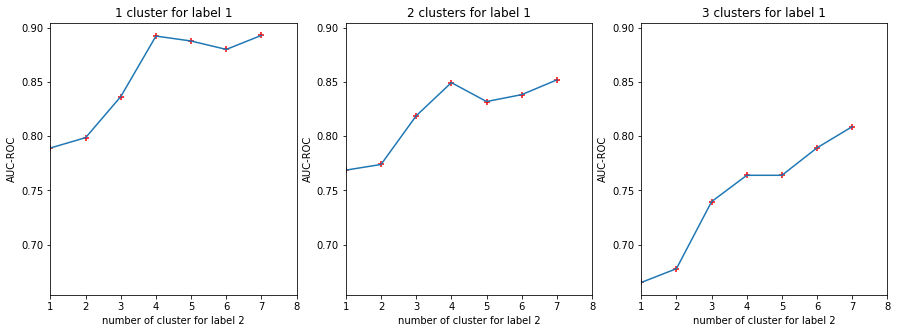

In [14]:
import matplotlib.pyplot as plt

z = 0
filename = ['auc_roc_boolean_repr_1_7.png', 'auc_roc_tf_repr_1_7.png', 'auc_roc_tf_idf_repr_1_7.png']
for df in [results_boolean, results_tf, results_tf_idf]:
    fig = plt.figure(figsize=(15,5))
    plt.title =  'AUC-ROC depending on the number of clusters'

    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
    ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)

    x, y = np.array(df[df['n_cluster_lab_1'] == 1]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 1]['aucroc'].tolist())
    ax1.plot(x, y)
    ax1.scatter(x, y, c='red', marker='+')
    ax1.set_title("1 cluster for label 1")
    ax1.set_xlim([1,8])
    ax1.set_xlabel("number of cluster for label 2")
    ax1.set_ylabel("AUC-ROC")

    x, y = np.array(df[df['n_cluster_lab_1'] == 2]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 2]['aucroc'].tolist())
    ax2.plot(x, y)
    ax2.scatter(x, y, c='red', marker='+')
    ax2.set_title("2 clusters for label 1")
    ax2.set_xlim([1,8])
    ax2.set_xlabel("number of cluster for label 2")
    ax2.set_ylabel("AUC-ROC")

    x, y = np.array(df[df['n_cluster_lab_1'] == 3]['n_cluster_lab_2'].tolist()), np.array(df[df['n_cluster_lab_1'] == 3]['aucroc'].tolist())
    ax3.plot(x, y)
    ax3.scatter(x, y, c='red', marker='+')
    ax3.set_title("3 clusters for label 1")
    ax3.set_xlim([1,8])
    ax3.set_xlabel("number of cluster for label 2")
    ax3.set_ylabel("AUC-ROC")

    plt.show()
    fig.savefig(fname=filename[z])
    z += 1

# Evaluation of clustering

In [9]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

best_model = k_means_centroids_model()
best_model.fit(x_train_boolean, y_train, n_cluster_1=1, n_cluster_0=6)
best_cluster = best_model.get_k_means_labels()

index_label_0 = np.argwhere(np.array(y_train) == 0).reshape(-1)
x_train_0 = x_train_boolean[index_label_0]

best_silhouette = silhouette_score(x_train_0, best_cluster[1])
best_ch_score = calinski_harabasz_score(x_train_0, best_cluster[1])
print('Best silhouette', best_silhouette, 'best ch score', best_ch_score)



centroid_model = k_means_centroids_model()
centroid_model.fit(x_train_boolean, y_train, n_cluster_1=1, n_cluster_0=3)
centroid_cluster = centroid_model.get_k_means_labels()

index_label_0 = np.argwhere(np.array(y_train) == 0).reshape(-1)
x_train_0 = x_train_boolean[index_label_0]

centroid_silhouette = silhouette_score(x_train_0, centroid_cluster[1])
centroid_ch_score = calinski_harabasz_score(x_train_0, centroid_cluster[1])
print('Centroid silhouette', centroid_silhouette, 'centroid ch score', centroid_ch_score)

print('done')

Best silhouette -0.014515277615406481 best ch score 20.99978743332352
Centroid silhouette 0.2540932566811898 centroid ch score 24.82724928688825
done


In [ ]:
best_model = k_means_centroids_model()
best_model.fit(x_train_boolean, y_train, n_cluster_1=1, n_cluster_0=7)
best_cluster = best_model.get_k_means_labels()

index_label_0 = np.argwhere(np.array(y_train) == 0).reshape(-1)
x_train_0 = x_train_boolean[index_label_0]

clustered_data = pd.DataFrame({'data':x_train_0, 'labels':best_cluster[1]})

count = dict({0:np.zeros(len(vocabulary)),
              1:np.zeros(len(vocabulary)),
              2:np.zeros(len(vocabulary)),
              3:np.zeros(len(vocabulary)),
              4:np.zeros(len(vocabulary)),
              5:np.zeros(len(vocabulary)),
              6:np.zeros(len(vocabulary))})

for i in range(7):
    for sentence in clustered_data[clustered_data['label']==i]['data']:
        for word in sentence:
            idx = np.where(x==word)
            count[i][idx] += 1

In [15]:
# get the k most frequent words
k = 30
for i in range(7):
    count[i] = np.sort(count[i])[::-1].head(k)


19635
